## Final Project Submission
Please fill out:
* Student name: David Rasmussen
* Student pace: full time
* Scheduled project review date/time: 10/29/2020 
* Instructor name: Rafael Carassco


## Import Libraries and Data

In [1]:
import numpy as np 
import pandas as pd
import time

import scipy.stats as scs 
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

%matplotlib inline

In [2]:
df = pd.read_csv("../data/cleaned_data.csv")

## Additional Cleaning and Engineering
I need to remove index and id columns.
I am also going to create two new boolean variables:
* whether or not the house has a basement
* whether or not the house has been renovated
There will be two continuous variables as well:
* price/sqft = price / sqft_living
* bed_to_bath_ratio

In [3]:
# remove 'Unnamed:' index column from cleaned_data.csv
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#remove 'id' column as I don't inted to use it
df.drop(columns=['id'], inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


I am going to do some engineering and create 4 new columns to see if I can find
any relationships to price
 * renovated:  Indicates whether or not the home has been renovated
 * has_basement: Indicates whether or note the home has any square feet in the basement indicated
 * bed_to_bath_ratio: The number of bedrooms in the house divided by the number of bathrooms
 * lake_zips: A one if inserted if any of the following zip codes are present 98033, 98039, 98004 and 98040.

In [5]:
df.loc[df['yr_renovated'] > 0.0 , 'renovated'] = 1.0
df.loc[df['sqft_basement'] > 0.0 , 'has_basement'] = 1.0
df.loc[df['zipcode'] == 98033, 'lake_zips'] = 1.0
df.loc[df['zipcode'] == 98039, 'lake_zips'] = 1.0
df.loc[df['zipcode'] == 98004, 'lake_zips'] = 1.0
df.loc[df['zipcode'] == 98040, 'lake_zips'] = 1.0
df['price/sqft'] = df['price'] / df['sqft_living']
df['bed_to_bath_ratio'] = df['bedrooms'] / df['bathrooms']

#filling null values where needed, using the mode '0'
df['renovated'] = df['renovated'].fillna(0.0)
df['has_basement'] = df['has_basement'].fillna(0.0)
df['lake_zips'] = df['lake_zips'].fillna(0.0)

In [6]:
df.loc[df.zipcode == 98033]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,has_basement,lake_zips,price/sqft,bed_to_bath_ratio
211,2014-06-10,1030000.0,5,4.00,3760,28040,2.0,0.0,3,10,...,98033,47.6489,-122.183,3430,35096,0.0,0.0,1.0,273.936170,1.250000
319,2014-08-19,604950.0,3,2.50,2110,5608,1.0,0.0,3,8,...,98033,47.6743,-122.184,2040,9363,0.0,1.0,1.0,286.706161,1.200000
419,2014-07-18,590000.0,4,2.75,2910,10650,1.0,0.0,3,8,...,98033,47.6658,-122.188,2920,10988,0.0,1.0,1.0,202.749141,1.454545
441,2014-10-15,1200000.0,4,2.50,2770,7800,2.0,0.0,3,10,...,98033,47.6840,-122.205,2720,10000,0.0,0.0,1.0,433.212996,1.600000
452,2015-05-07,750000.0,3,2.50,2400,7745,2.0,0.0,3,9,...,98033,47.6734,-122.173,2080,8615,0.0,0.0,1.0,312.500000,1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18946,2014-06-06,879950.0,4,2.75,3010,7215,2.0,0.0,3,9,...,98033,47.6952,-122.178,3010,7215,0.0,0.0,1.0,292.342193,1.454545
19048,2014-07-08,999000.0,4,2.50,3130,10849,2.0,0.0,3,10,...,98033,47.6828,-122.186,2470,9131,0.0,0.0,1.0,319.169329,1.600000
19169,2014-07-01,1020000.0,4,3.50,3770,8501,2.0,0.0,3,10,...,98033,47.6744,-122.196,1520,9660,0.0,0.0,1.0,270.557029,1.142857
19174,2014-07-10,875000.0,5,3.00,2960,15152,2.0,0.0,3,9,...,98033,47.6689,-122.179,1850,9453,0.0,0.0,1.0,295.608108,1.666667


In [7]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,has_basement,lake_zips,price/sqft,bed_to_bath_ratio
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,...,98178,47.5112,-122.257,1340,5650,0.0,0.0,0.0,188.050847,3.000000
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,...,98125,47.7210,-122.319,1690,7639,1.0,1.0,0.0,209.338521,1.333333
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,3,6,...,98028,47.7379,-122.233,2720,8062,0.0,0.0,0.0,233.766234,2.000000
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,...,98136,47.5208,-122.393,1360,5000,0.0,1.0,0.0,308.163265,1.333333
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,...,98074,47.6168,-122.045,1800,7503,0.0,0.0,0.0,303.571429,1.500000


## Exploratory Data Analysis
The goal is to asses if there are interesting relationships between variables.  I will look at how the data is distributed and whether there are potential correlations between variables.  

### Inserting/creating new variables

In [8]:
#create two groups of variables in order to visualize them seperately.
# a third variable is created to analyze all
continuous = ['price','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
              'yr_built','date', 'bed_to_bath_ratio','price/sqft']
categorical = ['bedrooms', 'bathrooms', 'floors', 'zipcode', 'grade', 'condition', 'waterfront', 'renovated',
               'has_basement', 'lake_zips']
all_variables = ['price','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built','date',
               'bedrooms', 'bathrooms', 'floors', 'zipcode', 'grade', 'condition', 'waterfront',
                 'renovated', 'has_basement','bed_to_bath_ratio','price/sqft','lake_zips']

### A look at all the data in general

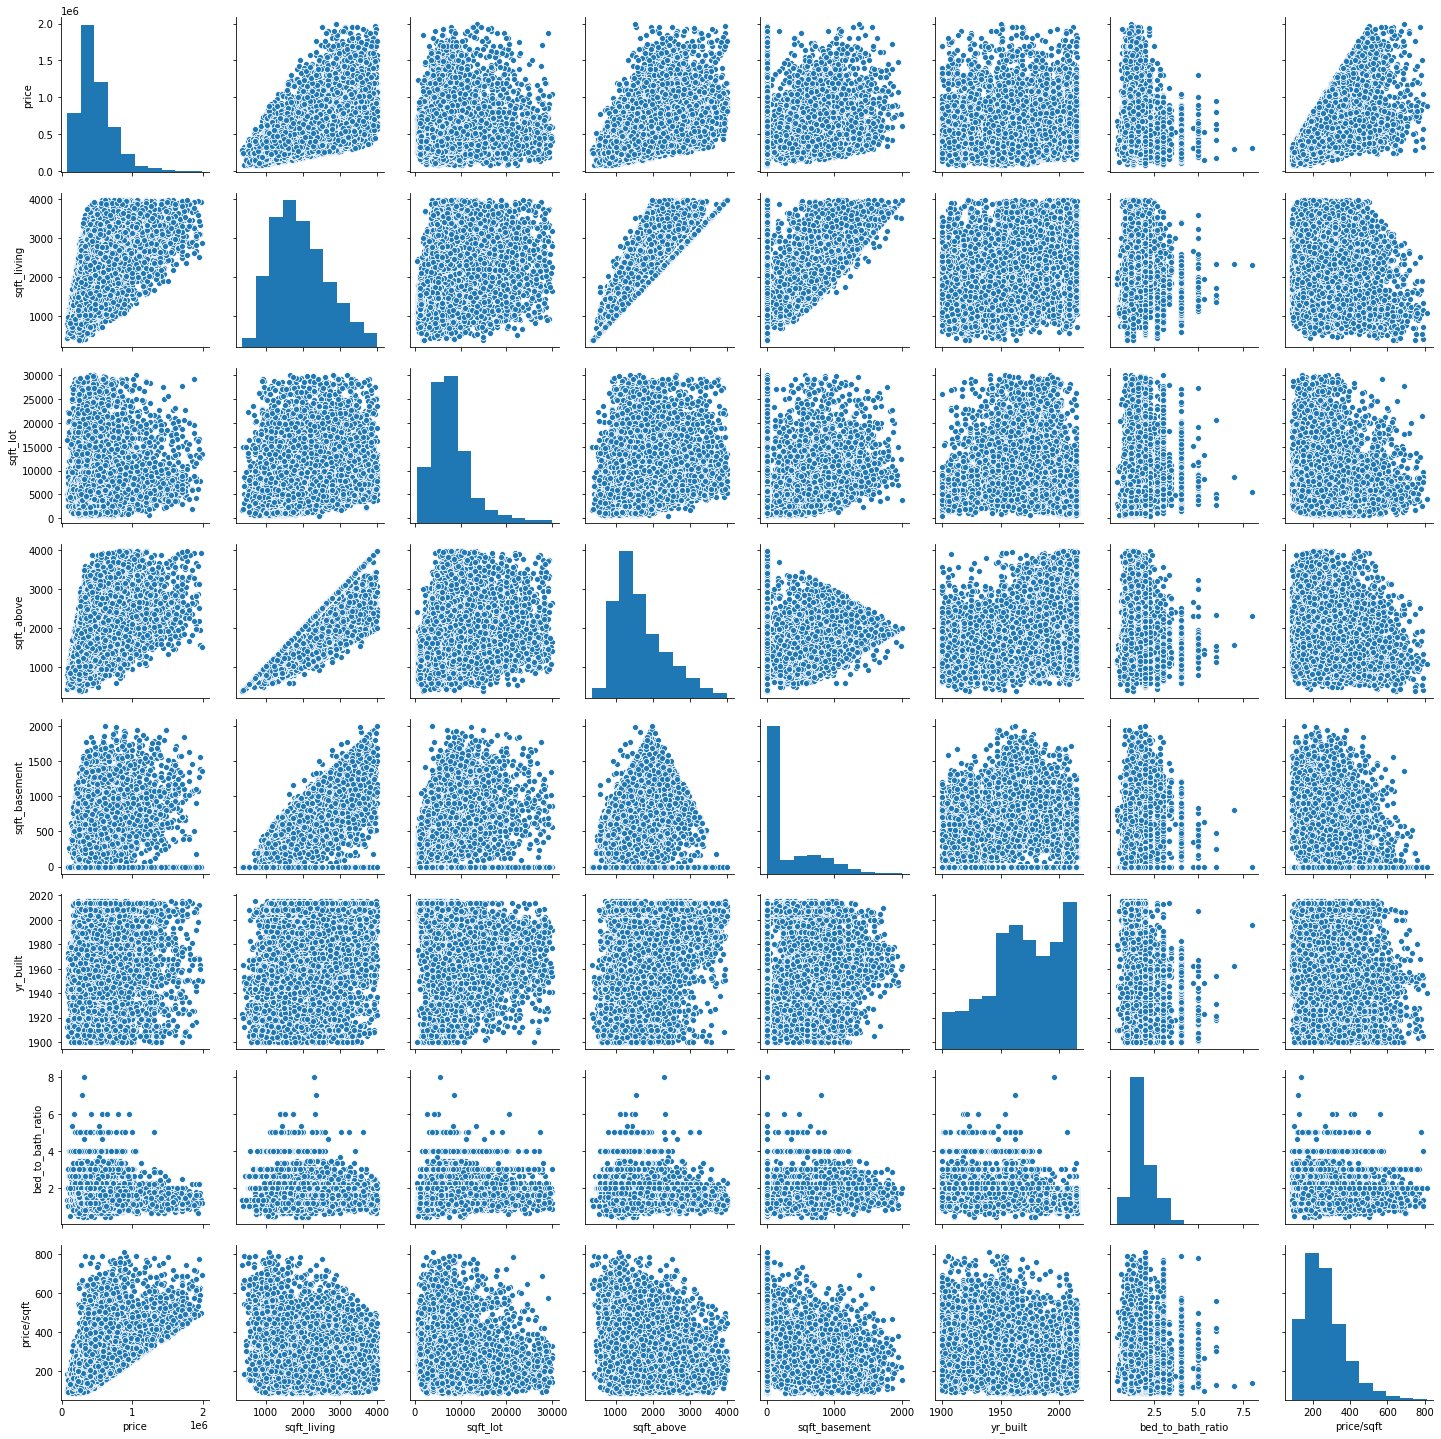

In [9]:
sns.pairplot(df[continuous])

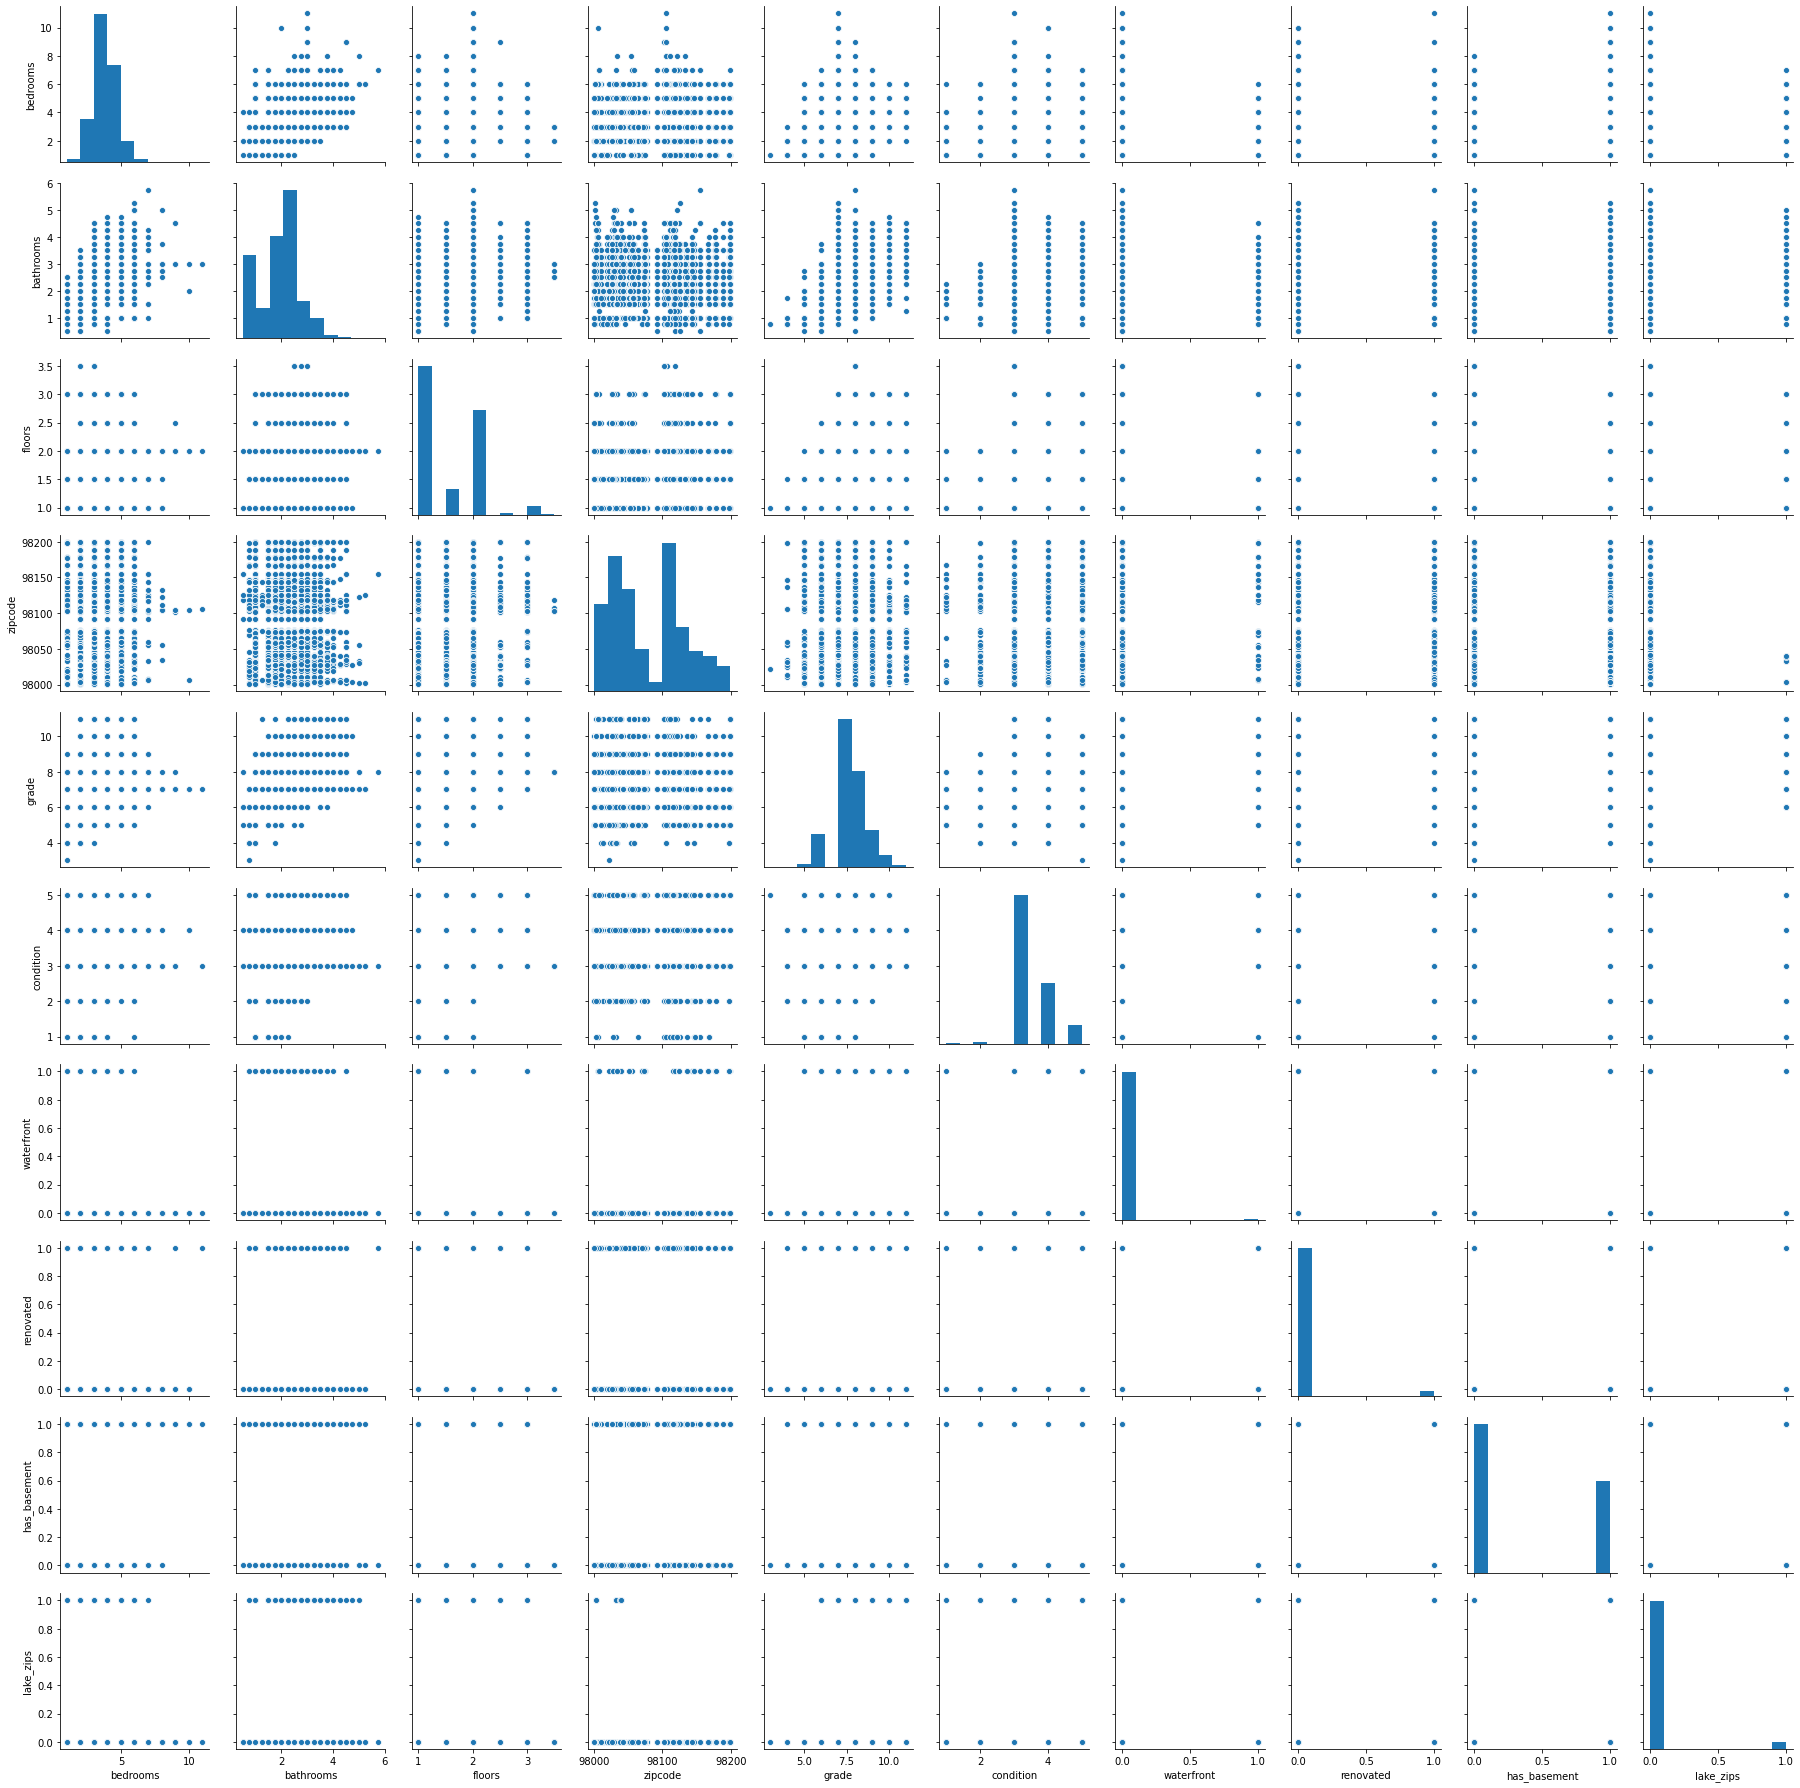

In [10]:
sns.pairplot(df[categorical])

In [11]:
#lets look at the correlation matrices for all variables.
#Looking for multicollinearity and variables that may help predict price
matrix = df[all_variables].corr()
matrix

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,bedrooms,bathrooms,floors,zipcode,grade,condition,waterfront,renovated,has_basement,bed_to_bath_ratio,price/sqft,lake_zips
price,1.000000,0.613178,0.060069,0.495029,0.267249,-0.002278,0.283691,0.435792,0.250291,-0.004129,0.626581,0.067500,0.154317,0.117101,0.191118,-0.226600,0.579222,0.343658
sqft_living,0.613178,1.000000,0.230812,0.836983,0.385249,0.316762,0.613073,0.711535,0.337299,-0.187114,0.698740,-0.049023,0.031573,0.044141,0.203238,-0.294872,-0.210838,0.126972
sqft_lot,0.060069,0.230812,1.000000,0.188705,0.096139,-0.030858,0.172276,0.005510,-0.277792,-0.229406,0.096136,0.094939,0.098655,0.009311,-0.013951,0.100929,-0.181983,0.142535
sqft_above,0.495029,0.836983,0.188705,1.000000,-0.173578,0.440954,0.485339,0.627500,0.538464,-0.265747,0.690444,-0.168523,0.011401,0.013489,-0.273282,-0.284080,-0.189323,0.107516
sqft_basement,0.267249,0.385249,0.096139,-0.173578,1.000000,-0.168680,0.278534,0.220189,-0.294540,0.109047,0.093701,0.189513,0.036479,0.056001,0.841070,-0.052762,-0.059504,0.048355
yr_built,-0.002278,0.316762,-0.030858,0.440954,-0.168680,1.000000,0.150338,0.521852,0.499067,-0.343066,0.453382,-0.359370,-0.032771,-0.199686,-0.171791,-0.433706,-0.317299,0.010385
bedrooms,0.283691,0.613073,0.172276,0.485339,0.278534,0.150338,1.000000,0.497470,0.154400,-0.157900,0.324215,0.031263,-0.021632,0.014226,0.148454,0.215111,-0.260849,0.077493
bathrooms,0.435792,0.711535,0.005510,0.627500,0.220189,0.521852,0.497470,1.000000,0.507751,-0.198201,0.607516,-0.127108,0.013358,0.042676,0.148640,-0.673457,-0.168237,0.069106
floors,0.250291,0.337299,-0.277792,0.538464,-0.294540,0.499067,0.154400,0.507751,1.000000,-0.057579,0.456966,-0.272362,0.006427,0.005270,-0.268579,-0.376350,-0.009818,-0.024869
zipcode,-0.004129,-0.187114,-0.229406,-0.265747,0.109047,-0.343066,-0.157900,-0.198201,-0.057579,1.000000,-0.168483,-0.007039,0.040107,0.067550,0.171549,0.116859,0.194597,-0.217642


Interestingly none of the variables seem to have a significant correlation to price/sqft.  I thought grade, condition, waterfront and bed/bath ratio would have a positive correlation to price/sqft.

### Question: Which independent variables have the greatest impact on price
A more focused analysis on variables that have more than a plus or minus 0.20 correlation to price

In [12]:
#pricefoi - features of interest when analyzing correlation to price.  
pricefoi = ['price', 'sqft_living', 'grade', 'sqft_above', 'bathrooms', 'bedrooms', 'sqft_basement', 'floors', 'bed_to_bath_ratio', 'lake_zips']

In [13]:
foimatrix = df[pricefoi].corr()
foimatrix

,price,sqft_living,grade,sqft_above,bathrooms,bedrooms,sqft_basement,floors,bed_to_bath_ratio,lake_zips
price,1.000000,0.613178,0.626581,0.495029,0.435792,0.283691,0.267249,0.250291,-0.226600,0.343658
sqft_living,0.613178,1.000000,0.698740,0.836983,0.711535,0.613073,0.385249,0.337299,-0.294872,0.126972
grade,0.626581,0.698740,1.000000,0.690444,0.607516,0.324215,0.093701,0.456966,-0.383095,0.132695
sqft_above,0.495029,0.836983,0.690444,1.000000,0.627500,0.485339,-0.173578,0.538464,-0.284080,0.107516
bathrooms,0.435792,0.711535,0.607516,0.627500,1.000000,0.497470,0.220189,0.507751,-0.673457,0.069106
bedrooms,0.283691,0.613073,0.324215,0.485339,0.497470,1.000000,0.278534,0.154400,0.215111,0.077493
sqft_basement,0.267249,0.385249,0.093701,-0.173578,0.220189,0.278534,1.000000,-0.294540,-0.052762,0.048355
floors,0.250291,0.337299,0.456966,0.538464,0.507751,0.154400,-0.294540,1.000000,-0.376350,-0.024869
bed_to_bath_ratio,-0.226600,-0.294872,-0.383095,-0.284080,-0.673457,0.215111,-0.052762,-0.376350,1.000000,-0.018309
lake_zips,0.343658,0.126972,0.132695,0.107516,0.069106,0.077493,0.048355,-0.024869,-0.018309,1.000000


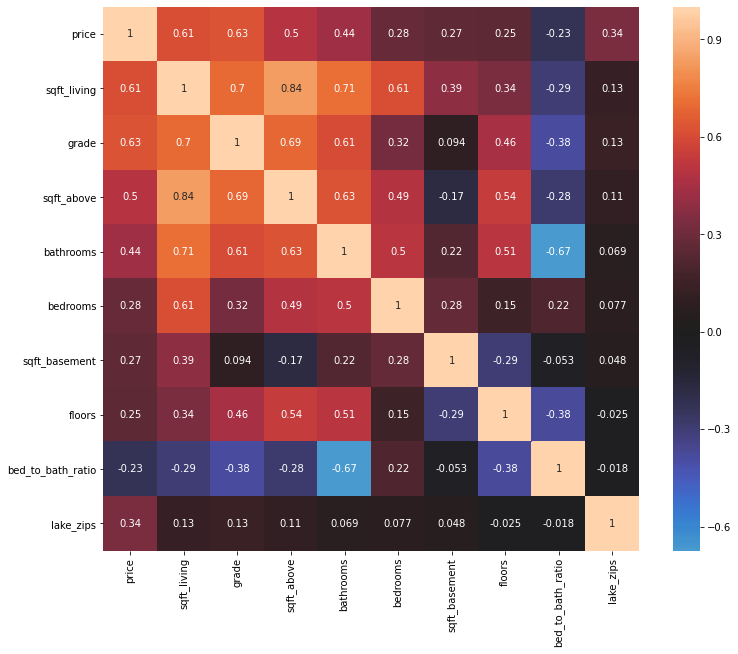

In [14]:
#Adding some color
plt.figure(figsize=(12,10))
sns.heatmap(foimatrix, center=0, annot=True);

Conclusion: The ‘grade’ variable has the highest correlation at 0.63.  Grade is categorical and based on a scale between 1-13.  The higher the grade, the higher the price.  The matrix highlights the how the variables are inter-correlated which is important when considering multicollinearity. 


#### Price and Sqft_living

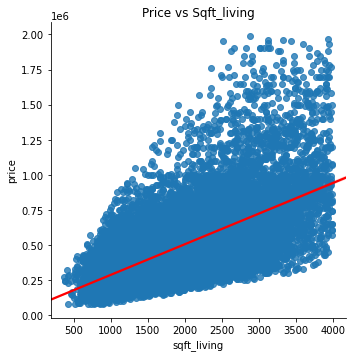

In [15]:
#closer look at price vs sqft_living.  This relationship is obvious and intuitive...
#...the bigger the house the higher the price
sns.lmplot(x='sqft_living', y='price', data=df, line_kws={'color': 'red'})
plt.title("Price vs Sqft_living".format('price', 'sqft_living'))
plt.show()

#### The relationship between price and grade

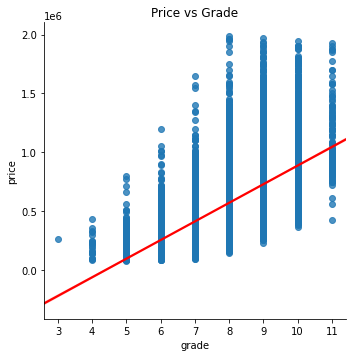

In [16]:
#higher grade equates to higher price. Makes sense
sns.lmplot(x='grade', y='price', data=df, line_kws={'color': 'red'})
plt.title("Price vs Grade".format('price', 'grade'))
plt.show()

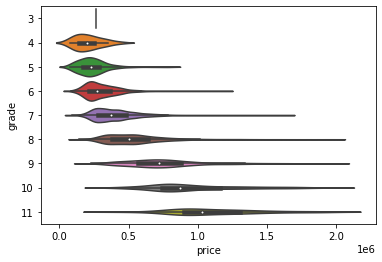

In [17]:
#I'll use a violin plot to show the dispersion of price in each grade category
sns.violinplot(x='price', y='grade', data=df, orient='h')
plt.show()

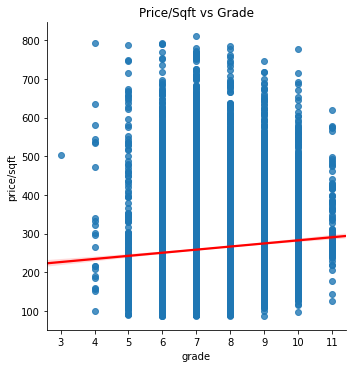

In [18]:
#A more precise question would be "how does grade affect price/sqft"
sns.lmplot(x='grade', y='price/sqft', data=df, line_kws={'color': 'red'})
plt.title("Price/Sqft vs Grade".format('price/sqft', 'grade'))
plt.show()

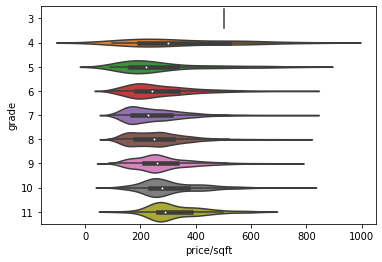

In [19]:
#Again, a violin plot to show the dispersion of price/sqft in each grade category
#The relationship is not as clear.  There must be a lot of noise another factor impacting price/sqft
sns.violinplot(x='price/sqft', y='grade', data=df, orient='h')
plt.show()

For context, here are the definitions of each grade from the King Country grading system:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

#### The relationship between price and number of bathrooms
There is a positive relationship between price and the number of bathrooms

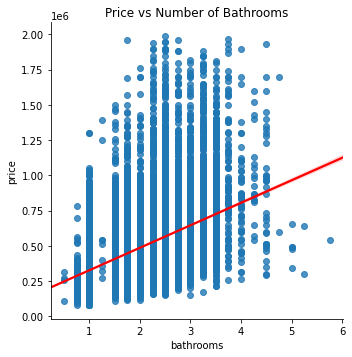

In [20]:
sns.lmplot(x='bathrooms', y='price', data=df, line_kws={'color': 'red'})
plt.title("Price vs Number of Bathrooms".format('price', 'bathrooms'))
plt.show()

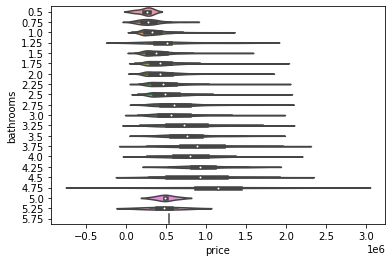

In [21]:
sns.violinplot(x='price', y='bathrooms', data=df, orient='h')
plt.show()

#### Question: How does the bed/bath ratio affect price?
Intuitively the more bedrooms that share a bathroom the lower the price of the house.  This hypothesis is correct

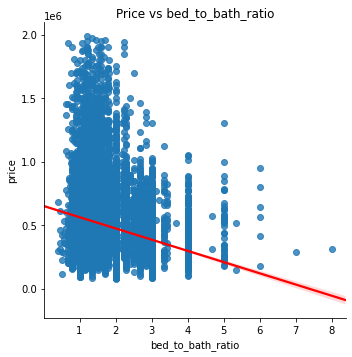

In [22]:
sns.lmplot(x='bed_to_bath_ratio', y='price', data=df, line_kws={'color': 'red'})
plt.title("Price vs bed_to_bath_ratio".format('price', 'bed_to_bath_ratio'))
plt.show()

Conclusion:  As expected there is a discernible negative relationships.  More bedrooms per bathroom equates to lower price 
The correlation between the two variables:  -0.23


#### Question:  What is the impact of location on price?
Rather than fiddle with a correlation matrix I decided to graph price on top of longitude and latitude.  

Text(0.5, 1.0, 'Price by Location')

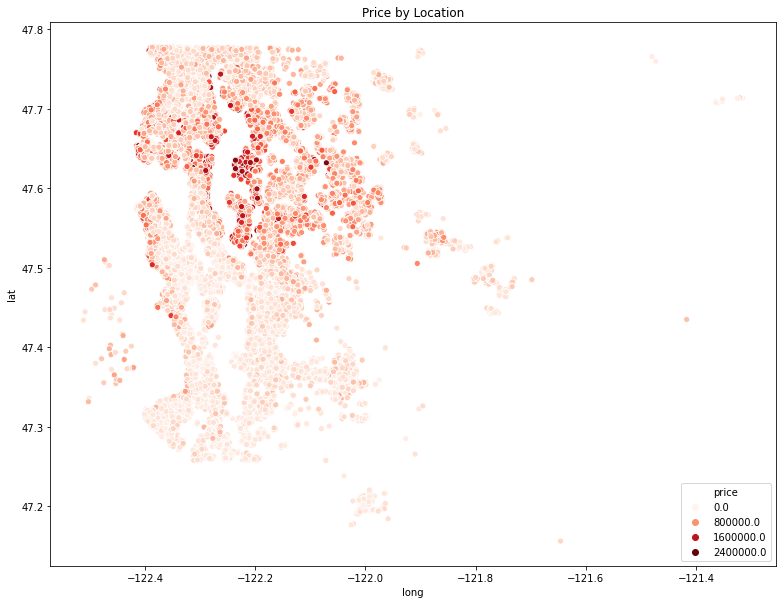

In [23]:
# A look at price verus location
plt.figure(figsize=(13,10))
sns.scatterplot(df['long'], df['lat\
'], hue=df['price'], palette='Reds')
plt.legend(loc='lower right')
plt.title("Price by Location")

By comparing the longitude and latitude heat map with the it looks like zip code 98033, 98039, 98004 and 98040 have the highest priced Real estate.  These are all clustered around Lake Washington  

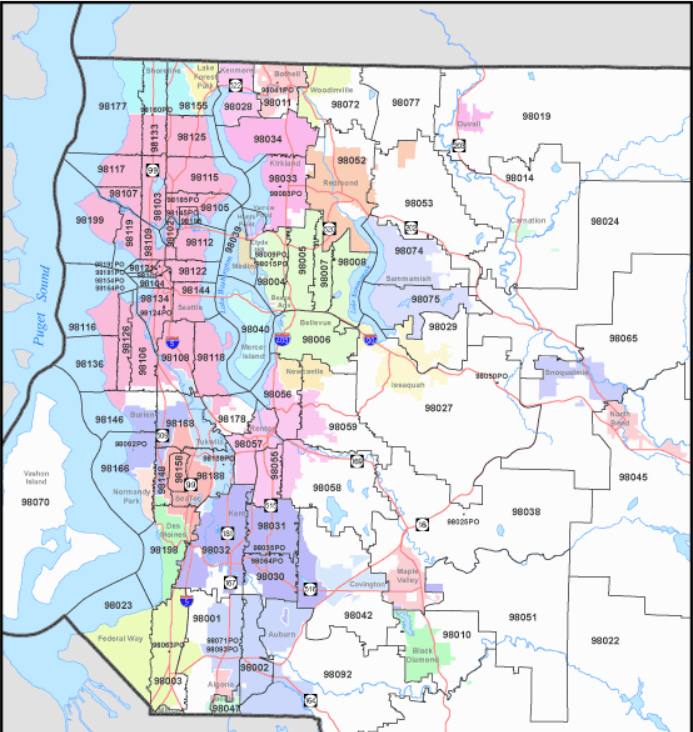

Text(0.5, 1.0, 'Price vs Lake Zipcodes')

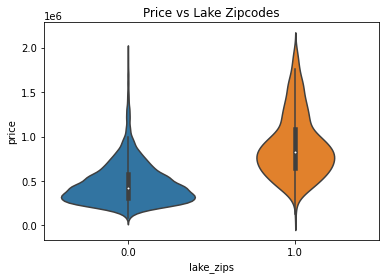

In [24]:
#Prices appear to be higher in the zip codes closes to the lake
sns.violinplot(x=df['lake_zips'],y=df['price'])
plt.title("Price vs Lake Zipcodes")

Conclusion:
The most expensive real estate is clustered around Lake Washington and the Seattle proper
The specific zip codes which the most expensive real estate are: 98033, 98039, 98004 and 98040


#### Other Relationships Analyzed
Here are some other relationships that I analyzed

Text(0.5, 1.0, 'Price vs Having a Basement')

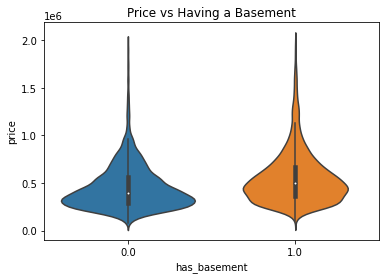

In [25]:
#There does not appear to be a remarkable relationship between price and whether or not there is a basement
sns.violinplot(x=df['has_basement'],y=df['price'])
plt.title("Price vs Having a Basement")

<Figure size 936x576 with 0 Axes>

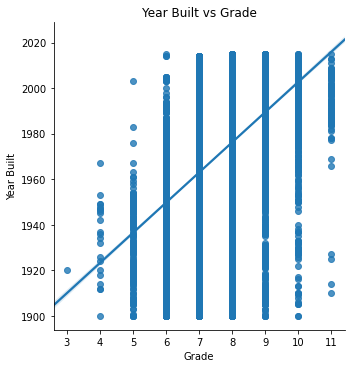

In [26]:
plt.figure(figsize=(13,8))
sns.lmplot(x='grade',y='yr_built',data=df)
ax = plt.gca()
ax.set(xlabel='Grade', ylabel='Year Built', title="Year Built vs Grade")
plt.show();

In [27]:
#export engineered data
df.to_csv('../data/engineered_data.csv')